In [1]:
library(cmapR)
ann <- read.delim('drugs/cmap_data/instinfo_beta.txt')

In [1]:
### create mouse 2 human entrez ID mapping

mouse2human <- function(human_ids){
    mart1 = useMart("ensembl", dataset="hsapiens_gene_ensembl")
    mart2 = useMart("ensembl", dataset="mmusculus_gene_ensembl") 

    # human / mouse
    human2mouse_df <-getLDS( attributes=c("entrezgene_id"), 
                            attributesL=c("entrezgene_id"),
                            filters="entrezgene_id", values=human_ids, 
                            mart=mart1, martL=mart2
                            )

    #one to one mapping filter
    hcol <- human2mouse_df[, 1]
    mcol <- human2mouse_df[, 2]
    ht <- as.data.frame(table(hcol))
    mt <- as.data.frame(table(mcol))
    one2one <- human2mouse_df[(hcol %in% ht[ht$Freq == 1,]$hcol) & (mcol %in% mt[mt$Freq == 1,]$mcol),]
    colnames(one2one) <- c('human', 'mouse')
    return(one2one)
}

In [4]:
hmn <- rownames(read.csv('tmp/hmn.csv', row.names=1))

In [5]:
res <- mouse2human(hmn)

ERROR: Error in useMart("ensembl", dataset = "hsapiens_gene_ensembl"): could not find function "useMart"


# Plot trajectories

In [2]:
#function to calculate linear model p-values for tAge prediction dynamics
fill_tAge_pvalues <- function(dataset_predictions,dataset_values=paste0(dataset_predictions$GEO,".",dataset_predictions$Treatment)){
  dataset_predictions$Dataset <- dataset_values
  output_table <- data.frame(Dataset=names(table(dataset_predictions$Dataset)))
  rownames(output_table) <- output_table$Dataset
  tAge_columns <- colnames(dataset_predictions)[grepl("tAge",colnames(dataset_predictions))]
  for (temp_model in tAge_columns){
    for (temp_dataset in unique(dataset_predictions$Dataset)){
      temp_data <- dataset_predictions[dataset_predictions$Dataset==temp_dataset,]
      temp_test <- summary(lm(temp_data[,temp_model]~temp_data$Time))
      temp_pvalue <- temp_test$coefficients[2,4]
      temp_slope <- temp_test$coefficients[2,1]
      if (temp_slope < 0){
        output_table[temp_dataset,temp_model] <- temp_pvalue
      }else{
        output_table[temp_dataset,temp_model] <- 1.0
      }
    }
  }
  output_table <- output_table
  return(output_table)
}


#function to visualize tAge dynamics plots
visualize_plots <- function(dataset_predictions,model,units="relative units",
                            separate_by_geo=T,
                            scaling=F,single_plot=T,add_mean_plot=T,
                            moving_average=F,step=1,point_size=5,
                            line_width=0.8,label_size=12,axis_size=12,
                            point_alpha=1,legend_size=16,
                            title_size=12,
                            legend_within=F,folder=getwd(),
                            file_name=F){
  setwd(folder)
  library(ggplot2)
  data_for_ggplot <- data.frame(GEO=dataset_predictions$GEO,
                                Treatment=dataset_predictions$Treatment,
                                tAge=dataset_predictions[,model],
                                Time=dataset_predictions$Time)
  data_for_ggplot$Dataset <- paste0(data_for_ggplot$GEO,".",data_for_ggplot$Treatment)
  if (scaling==T){
    for (temp_dataset in levels(factor(data_for_ggplot$Dataset))){
      data_for_ggplot[data_for_ggplot$Dataset==temp_dataset,]$tAge <- scale(data_for_ggplot[data_for_ggplot$Dataset==temp_dataset,]$tAge,center = F,scale = T)
    }
  }
  print(data_for_ggplot[data_for_ggplot$Time==0,]$tAge)
  pvalues_table <- fill_tAge_pvalues(data_for_ggplot)
  pvalues_table$tAge <- p.adjust(pvalues_table$tAge,"BH")
  pvalues_table$Label <- ifelse(pvalues_table$tAge >=0.05,"",
                                ifelse(pvalues_table$tAge>=0.01,"*",
                                       ifelse(pvalues_table$tAge>=0.001,"**","***")))
  y_label <- paste0("tAge, ",units)
  
  
  if (single_plot==F){
    for (temp_GEO in levels(factor(data_for_ggplot$GEO))){
      temp_data <- data_for_ggplot[data_for_ggplot$GEO==temp_GEO,]
      temp_data$Dataset <- paste0(temp_data$GEO,".",temp_data$Treatment)
      temp_data$Treatment <- paste0(temp_data$Treatment," ", pvalues_table[temp_data$Dataset,]$Label)
      t <- ggplot(temp_data,aes(x=Time,y=tAge))+
        labs(title=temp_GEO,x="Days of reprogramming",y=y_label)+
        theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
        geom_smooth(aes(color=Treatment),formula = y~x,method = "lm",se = F,lwd=line_width,alpha=0.5)+
        geom_point(aes(fill=Treatment),colour="black",size=point_size,shape=21,alpha=point_alpha)+
        theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
              axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
              axis.text.y = element_text(size=12,color="black"),
              axis.title=element_text(size=18),
              legend.title=element_text(size=legend_size+2,color="black"),
              legend.text=element_text(size=legend_size,color="black"),
              legend.key.size = unit(1.5, 'lines'),
              panel.grid = element_blank())+
        theme(plot.title = element_text(size=26))
      
      pdf(paste0(temp_GEO,".",model, ".pdf"),
          paper = "a4r",width = 14)
      print(t)
      dev.off()
      print(t)
      
    }
    
  }else{
    if (separate_by_geo==T){
      if (class(file_name)=="logical"){
        file_name <- paste0("Aggregated",".",model, ".pdf")
      }

      t <- ggplot(data_for_ggplot,aes(x=Time,y=tAge))+
        facet_wrap(~GEO,scales="free")+
        labs(x="Days of reprogramming",y=y_label)+
        theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
        geom_smooth(aes(color=Treatment),formula = y~x,method = "lm",se = F,lwd=line_width,alpha=0.5)+
        geom_point(aes(fill=Treatment),colour="black",size=point_size,shape=21,alpha=point_alpha)+
        theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
              axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
              axis.text.y = element_text(size=12,color="black"),
              axis.title=element_text(size=18),
              legend.title=element_text(size=legend_size+2,color="black"),
              legend.text=element_text(size=legend_size,color="black"),
              legend.key.size = unit(1.5, 'lines'),
              panel.grid = element_blank(),
              strip.background =element_rect(fill="white"),
              strip.text = element_text(size=label_size,face="bold"))
      pdf(file_name,
          paper = "a4r",width = 24)
      print(t)
      dev.off()
      
      print(t)
    }else{
      if (class(file_name)=="logical"){
        file_name <- ifelse(scaling==F,paste0("Combined",".",model, ".pdf"),
                            paste0("Combined.Scaled.",model, ".pdf"))
      }
      pvalues_table <- fill_tAge_pvalues(data_for_ggplot,data_for_ggplot$Treatment)
      pvalues_table$tAge <- p.adjust(pvalues_table$tAge,"BH")
      pvalues_table$Label <- ifelse(pvalues_table$tAge >=0.05,"",
                                    ifelse(pvalues_table$tAge>=0.01,"*",
                                           ifelse(pvalues_table$tAge>=0.001,"**","***")))
      data_for_ggplot$Treatment <- paste0(data_for_ggplot$Treatment," ", pvalues_table[data_for_ggplot$Treatment,]$Label)
      
      if (length(unique(data_for_ggplot$Treatment))>1){
        t <- ggplot(data_for_ggplot,aes(x=Time,y=tAge))+
          labs(x="Days of reprogramming",y=y_label)+
          theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
          geom_smooth(aes(color=Treatment),formula = y~x,method = "lm",se = F,lwd=line_width,alpha=0.5)+
          geom_point(aes(fill=Treatment),colour="black",size=point_size,shape=21,alpha=point_alpha)+
          theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
                axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
                axis.text.y = element_text(size=12,color="black"),
                axis.title=element_text(size=18),
                legend.title=element_text(size=legend_size+2,color="black"),
                legend.text=element_text(size=legend_size,color="black"),
                legend.key.size = unit(1.5, 'lines'),
                panel.grid = element_blank(),
                strip.background =element_rect(fill="white"),
                strip.text = element_text(size=label_size,face="bold"))
      }else{
        t <- ggplot(data_for_ggplot,aes(x=Time,y=tAge))+
          labs(x="Days of reprogramming",y=y_label)+
          theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
          geom_smooth(color="black",formula = y~x,method = "loess",se = F,lwd=line_width,alpha=0.5)+
          geom_point(aes(fill=GEO),colour="black",size=point_size,shape=21,alpha=point_alpha)+
          theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
                axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
                axis.text.y = element_text(size=12,color="black"),
                axis.title=element_text(size=18),
                legend.title=element_text(size=legend_size+2,color="black"),
                legend.text=element_text(size=legend_size,color="black"),
                legend.key.size = unit(1.5, 'lines'),
                panel.grid = element_blank(),
                strip.background =element_rect(fill="white"),
                strip.text = element_text(size=label_size,face="bold"))
      }
      pdf(file_name,
          paper = "a4r",width = 24)
      print(t)
      dev.off()
      print(t)
      
      if(add_mean_plot==T){
        #      data_for_ggplot$Time <- floor(data_for_ggplot$Time/step)*step
        time_points <- sort(as.numeric(unique(data_for_ggplot$Time)))
        print(time_points)
        
        if (moving_average==T){
          output_table <- data_for_ggplot[1,,F]
          for (t in 1:(length(time_points)-step)){
            if (t<=step){
              temp_time <- time_points[1:t]
            }else{
              temp_time <- time_points[c((t-step):(t+step))]
            }
            mean_time <- mean(temp_time)
            temp_data <- data_for_ggplot[data_for_ggplot$Time %in% temp_time,]
            temp_data$Time <- mean_time
            output_table <- rbind(output_table,temp_data)
          }
          output_table <- output_table[-1,]
          data_for_ggplot <- output_table
          
        }else{
          
          temp_vector <- c()
          for (temp_time in time_points){
            temp_vector <- c(temp_vector,rep(temp_time,sum(data_for_ggplot$Time==temp_time)))
            if (length(temp_vector) >= step){
              mean_time <- mean(temp_vector)
              data_for_ggplot[data_for_ggplot$Time %in% temp_vector,]$Time <- mean_time
              temp_vector <- c()
            }
          }
        }
        
        data_mean <- matrix(ncol=5)
        for (temp_treatment in levels(factor(data_for_ggplot$Treatment))){
          temp_data <- data_for_ggplot[data_for_ggplot$Treatment==temp_treatment,]
          temp_data$Time <- as.factor(temp_data$Time)
          for (temp_time in levels(factor(temp_data$Time))){
            temp_temp_data <- temp_data[temp_data$Time==temp_time,]
            if (nrow(temp_temp_data)>1){
              data_mean <- rbind(data_mean,c(temp_treatment,temp_time,nrow(temp_temp_data),
                                             mean(temp_temp_data$tAge),
                                             sd(temp_temp_data$tAge)/sqrt(nrow(temp_temp_data))))
            }else{
              data_mean <- rbind(data_mean,c(temp_treatment,temp_time,nrow(temp_temp_data),
                                             mean(temp_temp_data$tAge),
                                             sd(temp_temp_data$tAge)/sqrt(nrow(temp_temp_data))))
            }
          }
        }
        data_mean <- as.data.frame(data_mean)
        data_mean <- data_mean[-1,]
        colnames(data_mean) <- c("Treatment","Time","Number","Mean","SE")
        data_mean$Mean <- as.numeric(data_mean$Mean)
        data_mean$SE <- as.numeric(data_mean$SE)
        data_mean$CI_low <- data_mean$Mean-data_mean$SE
        data_mean$CI_high <- data_mean$Mean+data_mean$SE
        data_mean$Time <- as.numeric(as.character(data_mean$Time))
        limits <- aes(ymin=CI_low,ymax=CI_high)
        t <- ggplot(data_mean,aes(x=Time,y=Mean,fill=Treatment))+
          labs(x="Days of reprogramming",y=y_label)+
          theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
          geom_line(aes(color=Treatment),lwd=line_width)+
          geom_point(colour="black",size=point_size,shape=21,alpha=point_alpha)+
          geom_errorbar(limits,width=0.3,size=0.7,position=position_dodge(0.8))+
          theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
                axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
                axis.text.y = element_text(size=12,color="black"),
                axis.title=element_text(size=18),
                legend.title=element_text(size=legend_size+2,color="black"),
                legend.text=element_text(size=legend_size,color="black"),
                legend.key.size = unit(1.5, 'lines'),
                panel.grid = element_blank(),
                strip.background =element_rect(fill="white"),
                strip.text = element_text(size=label_size,face="bold"))
        file_name <- gsub("[.]pdf","",file_name)
        pdf(paste0(file_name,".Means.pdf"),
            paper = "a4r",width = 24)
        print(t)
        dev.off()
        print(t)
        return(data_mean)
      }
      
    }
  }
}

In [3]:
clockm <- read.csv('clocks/Mouse_clock_output.csv', row.names=1)
#clockh <- read.csv('clocks/Human_clock_output.csv', row.names=1)
clockh <- read.csv('clocks/final/Human_predictions_clock.csv', row.names=1)

In [4]:
#I. Mouse data
#1. Download and preprocess tAge predictions
mouse_predictions <- clockm

mouse_predictions$GEO <- mouse_predictions$GSE
mouse_predictions$tAge <- mouse_predictions$AgeNorm
mouse_predictions$tAge_model_mouse_norm <-mouse_predictions$tAge

mouse_predictions$Treatment <- gsub("OKMS","OSKM",mouse_predictions$Treatment)
mouse_predictions$Treatment <- gsub("OSKM\\+dox_mef","OSKM",mouse_predictions$Treatment)
mouse_predictions$Treatment <- gsub("OSKM_WT-1","OSKM", mouse_predictions$Treatment)
table(mouse_predictions$Treatment)
mouse_predictions$Dataset <- paste0(mouse_predictions$GEO,".",mouse_predictions$Treatment)
output_mouse <- fill_tAge_pvalues(mouse_predictions)
output_mouse$tAge <- p.adjust(output_mouse$tAge,"BH")


             7F        7F-Esrrb        7F-Glis1         7F-Jdp2        7F-Kdm2b 
             10               5               5               5               5 
        7F-Mkk6        7F-Nanog        7F-Sall4    C/EBPα- OSKM    C/EBPα+ OSKM 
              5               5               5              18              18 
            GFP   Oct4+defSox+K         Oct4+SK         Oct6+SK          OK+9MS 
             25              10              10              10               4 
            OSK            OSKM OSKM_Gatad2a-/-    OSKM_Mbd3f/-       OSKM_WT-2 
              6              67               9               9               5 
   OSKM-dox_mef 
             10 

In [5]:
unique(mouse_predictions$Treatment)

[1] "OSKM"            "OSK"             "GFP"             "OK+9MS"         
 [5] "C/EBPα+ OSKM"    "C/EBPα- OSKM"    "Oct4+SK"         "Oct6+SK"        
 [9] "Oct4+defSox+K"   "OSKM-dox_mef"    "7F-Esrrb"        "7F-Glis1"       
[13] "7F-Jdp2"         "7F-Kdm2b"        "7F-Mkk6"         "7F-Nanog"       
[17] "7F-Sall4"        "7F"              "OSKM_Gatad2a-/-" "OSKM_Mbd3f/-"   
[21] "OSKM_WT-2"

In [6]:
#Specify datasets with significant rejuvenation effect
FDR_thresh <- 0.05
significant_mouse_model <- output_mouse[output_mouse$tAge_model_mouse_norm<FDR_thresh,]$Dataset
oskm_predictions <- mouse_predictions[mouse_predictions$Treatment=="OSKM" & (mouse_predictions$Dataset %in% significant_mouse_model),]

[1] 1.924952 1.796429 1.790343 1.778951 1.539917
 [1]  0.0  0.5  1.0  1.5  2.0  2.5  3.0  4.0  5.0  6.0  7.0  8.0 10.0 11.0 12.0
[16] 15.0 16.0 18.0 21.0


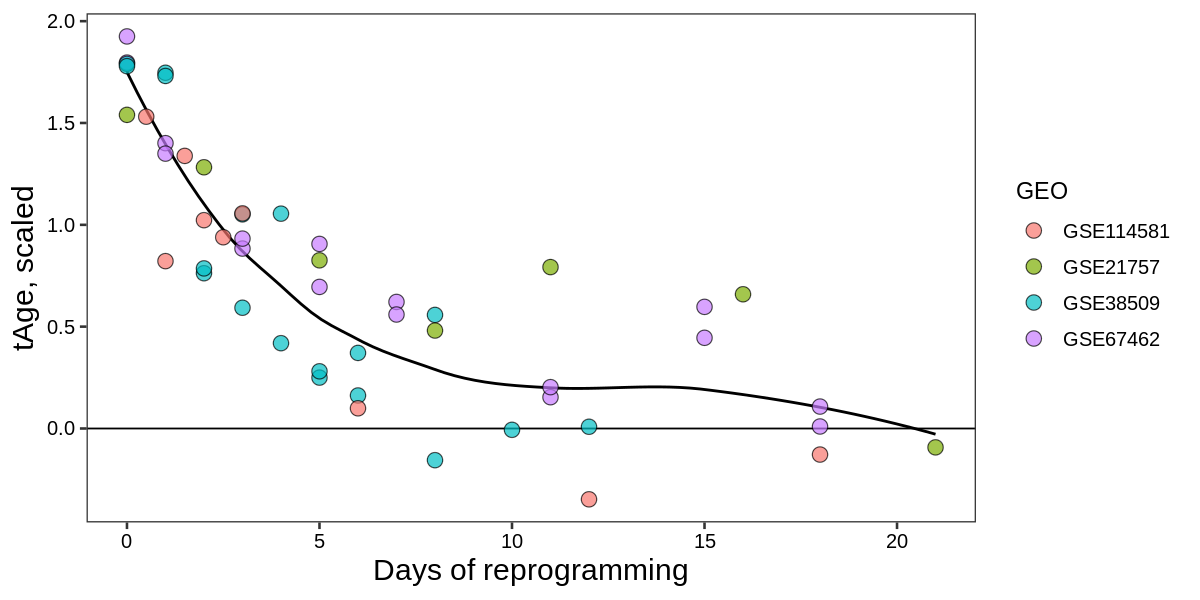

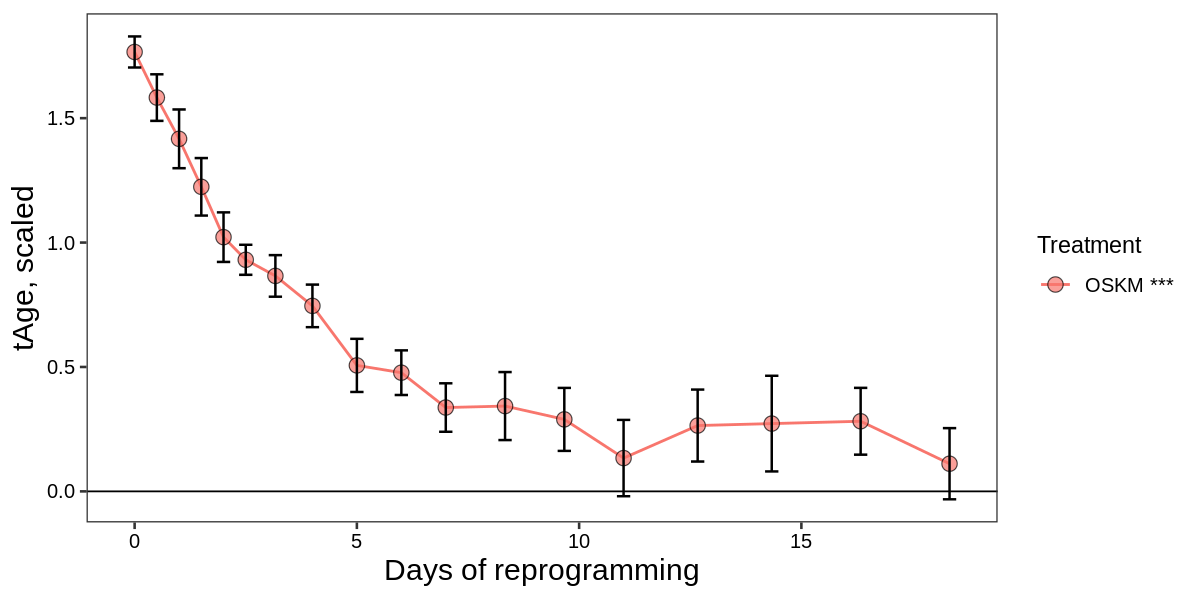

In [7]:
#Build moving average plots (with the step of +-1)
options(repr.plot.width = 10, repr.plot.height = 5)
mouse_ma_output <- visualize_plots(oskm_predictions,
                                   "tAge_model_mouse_norm","scaled",single_plot = T,
                                   separate_by_geo = F,scaling = T,moving_average = T,
                                   point_size = 4,point_alpha=0.7,axis_size=10,
                                   title_size=12,
                                   label_size=12,legend_size=12,
                                   line_width=0.8,legend_within = F,step=1,
                                   file_name="OSKM.tAge_model_mouse_norm.Scaled_MA.pdf")
mouse_ma_output$Species <- "Mouse"

In [8]:

#4. Save output table
bad_models <- colnames(mouse_predictions)[grepl("tAge",colnames(mouse_predictions))]
chosen_models <- c("tAge_model_mouse_norm")
bad_models <- setdiff(bad_models,chosen_models)
mouse_predictions <- mouse_predictions[,!(colnames(mouse_predictions) %in% bad_models)]

for (temp_model in chosen_models){
  for (temp_dataset in levels(factor(mouse_predictions$Dataset))){
    mouse_predictions[mouse_predictions$Dataset==temp_dataset,paste0(temp_model,".Scaled")] <- scale(mouse_predictions[mouse_predictions$Dataset==temp_dataset,temp_model],center = F,scale = T)
  }  
}
colnames(mouse_predictions) <- gsub("_norm","",colnames(mouse_predictions))
colnames(mouse_predictions) <- gsub("_model","",colnames(mouse_predictions))
head(mouse_predictions)
write.csv(mouse_predictions,"tmp/Mouse_predictions_clock.csv",row.names = F)

,ID,GSE,Treatment,GSM,Time,BatchTreatment,Dataset,AgeNorm,GEO,tAge_mouse,tAge_mouse.Scaled
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,"<dbl[,1]>"
1,GSE67462$OSKM$$GSM1647454,GSE67462,OSKM,GSM1647454,0,OSKM,GSE67462.OSKM,0.14929771,GSE67462,0.14929771,1.9249517
2,GSE67462$OSKM$$GSM1647455,GSE67462,OSKM,GSM1647455,0,OSKM,GSE67462.OSKM,0.13932956,GSE67462,0.13932956,1.7964286
3,GSE67462$OSKM$$GSM1647456,GSE67462,OSKM,GSM1647456,1,OSKM,GSE67462.OSKM,0.10865417,GSE67462,0.10865417,1.4009191
4,GSE67462$OSKM$$GSM1647457,GSE67462,OSKM,GSM1647457,1,OSKM,GSE67462.OSKM,0.10466631,GSE67462,0.10466631,1.3495022
5,GSE67462$OSKM$$GSM1647458,GSE67462,OSKM,GSM1647458,3,OSKM,GSE67462.OSKM,0.06851137,GSE67462,0.06851137,0.8833429
6,GSE67462$OSKM$$GSM1647459,GSE67462,OSKM,GSM1647459,3,OSKM,GSE67462.OSKM,0.07229921,GSE67462,0.07229921,0.9321810


In [9]:
#II. Human
#1. Download and preprocess tAge predictions
human_predictions <- clockh

human_predictions$tAge <- human_predictions$AgeNorm
human_predictions$tAge_model_human_norm <-human_predictions$tAge

human_predictions$Dataset <- paste0(human_predictions$GEO,".",human_predictions$Treatment)
output_human <- fill_tAge_pvalues(human_predictions)
nrow(output_human)
#12 datasets in total
FDR_thresh <- 0.05
output_human[,grepl("tAge",colnames(output_human))] <- apply(output_human[,grepl("tAge",colnames(output_human))],2,function(x){p.adjust(x,"BH")})
apply(output_human[,grepl("tAge",colnames(output_human))],2,
      function(x){sum(x<FDR_thresh)})
#Norm mouse and human models are the best:)


[1] 12

tAge_mouse            tAge_human     tAge_human.Scaled 
                   10                     8                     8 
    tAge_mouse.Scaled                  tAge tAge_model_human_norm 
                   10                     8                     8

 [1] 1.5973633 1.4987757 1.5222724 1.3533756 1.5720002 1.8515796 1.2376375
 [8] 0.8443242 1.3932111 0.7799506 0.7668657 0.7587156 0.8502016 0.3062819
[15] 0.3209535 1.6314858 1.7392718 1.4325854 1.1898238 1.4639488 1.4715582
[22] 1.3436514 1.0614444 1.0947283 1.4004120
 [1]  0  3  7 11 15 20 28 35 42 49


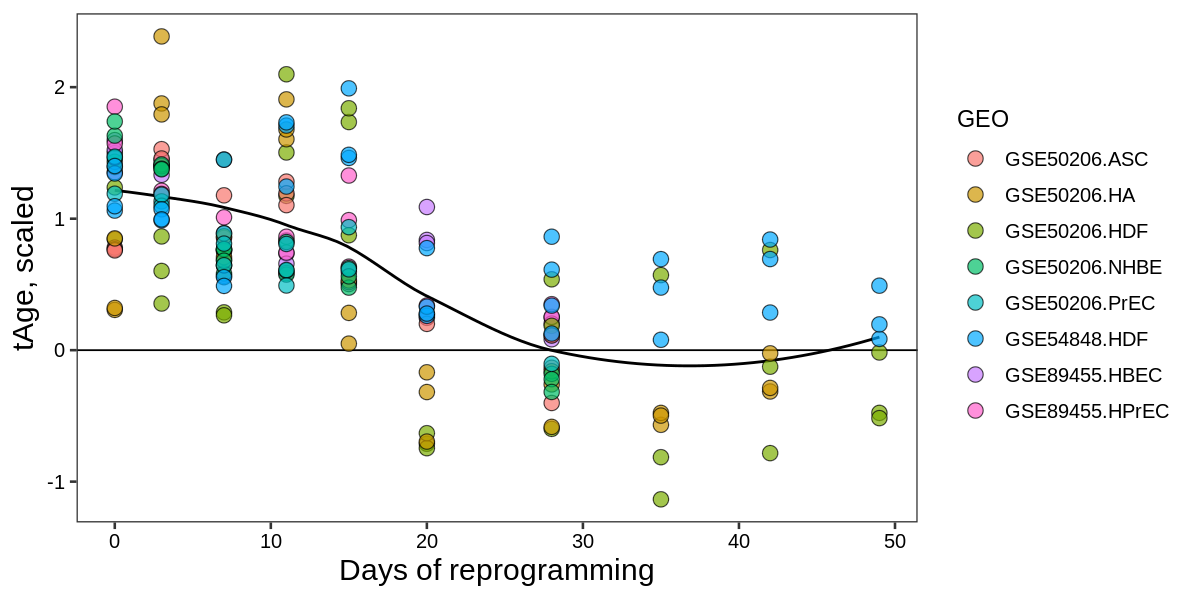

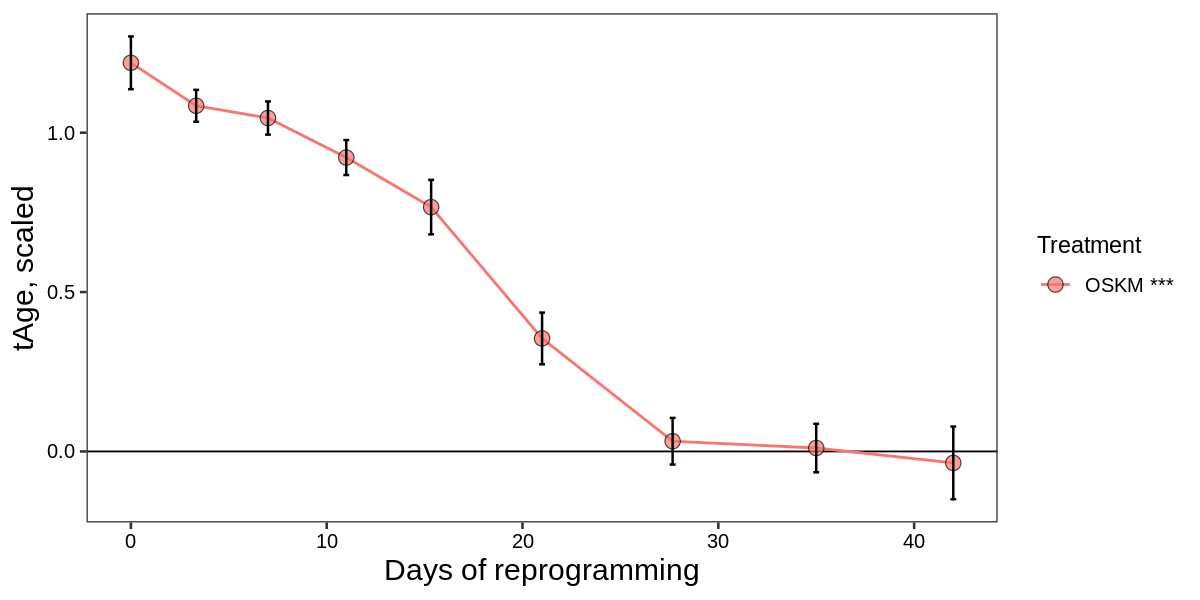

In [10]:

#Specify datasets with significant rejuvenation effect
significant_human_model <- output_human[output_human$tAge_model_human_norm<FDR_thresh,]$Dataset
#significant_mouse_model <- output_human[output_human$tAge_model_mouse_norm<FDR_thresh,]$Dataset
#significant_mouse_model <- setdiff(significant_mouse_model,"GSE28688.OSKM_HFF")


#Build moving average plots (with the step of +-1)
temp_human <- human_predictions
temp_human$Treatment <- gsub("OSKM_","",temp_human$Treatment)
temp_human$GEO <- paste(temp_human$GEO,temp_human$Treatment,sep=".")
temp_human$Treatment <- "OSKM"
#Human clock
human_ma_output <- visualize_plots(temp_human[temp_human$Dataset %in% significant_human_model,],
                                   "tAge_model_human_norm","scaled",single_plot = T,
                                   separate_by_geo = F,scaling = T,
                                   point_size = 4,point_alpha=0.7,axis_size=10,
                                   title_size=12,moving_average = T,
                                   label_size=12,legend_size=12,
                                   line_width=0.8,legend_within = F,step=1,
                                   file_name="tmp/OSKM.tAge_model_human_norm.Scaled_MA.pdf")
human_ma_output$Species <- "Human"


In [11]:

#4. Save output table
bad_models <- colnames(human_predictions)[grepl("tAge",colnames(human_predictions))]
chosen_models <- c("tAge_model_human_norm")
bad_models <- setdiff(bad_models,chosen_models)
human_predictions <- human_predictions[,!(colnames(human_predictions) %in% bad_models)]

for (temp_model in chosen_models){
  for (temp_dataset in levels(factor(human_predictions$Dataset))){
    human_predictions[human_predictions$Dataset==temp_dataset,paste0(temp_model,".Scaled")] <- scale(human_predictions[human_predictions$Dataset==temp_dataset,temp_model],center = F,scale = T)
  }  
}
colnames(human_predictions) <- gsub("_norm","",colnames(human_predictions))
colnames(human_predictions) <- gsub("_model","",colnames(human_predictions))
head(human_predictions)
write.csv(human_predictions,"tmp/Human_predictions_clock.csv",row.names = F)

,ID,Dataset,GEO,Treatment,Time,AgeNorm,Tissue,tAge_human,tAge_human.Scaled
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<dbl>,"<dbl[,1]>"
1,GSE89455.OSKM.HDF.GSM2372432,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,0,0.13425485,DF,0.13425485,0.8800374
2,GSE89455.OSKM.HDF.GSM2372433,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,0,0.12798792,DF,0.12798792,0.8389578
3,GSE89455.OSKM.HDF.GSM2372434,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,0,0.17139022,DF,0.17139022,1.1234589
4,GSE89455.OSKM.HDF.GSM2372435,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,3,0.11609636,DF,0.11609636,0.7610089
5,GSE89455.OSKM.HDF.GSM2372436,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,3,0.09225089,DF,0.09225089,0.6047024
6,GSE89455.OSKM.HDF.GSM2372437,GSE89455.OSKM_HDF,GSE89455,OSKM_HDF,3,0.10495103,DF,0.10495103,0.6879515


In [17]:
write.csv(ma_outputs, "clocks/trajectories.csv")

[1] 1.766118
[1] 1.219297
[1] 1.766118
[1] 1.219297


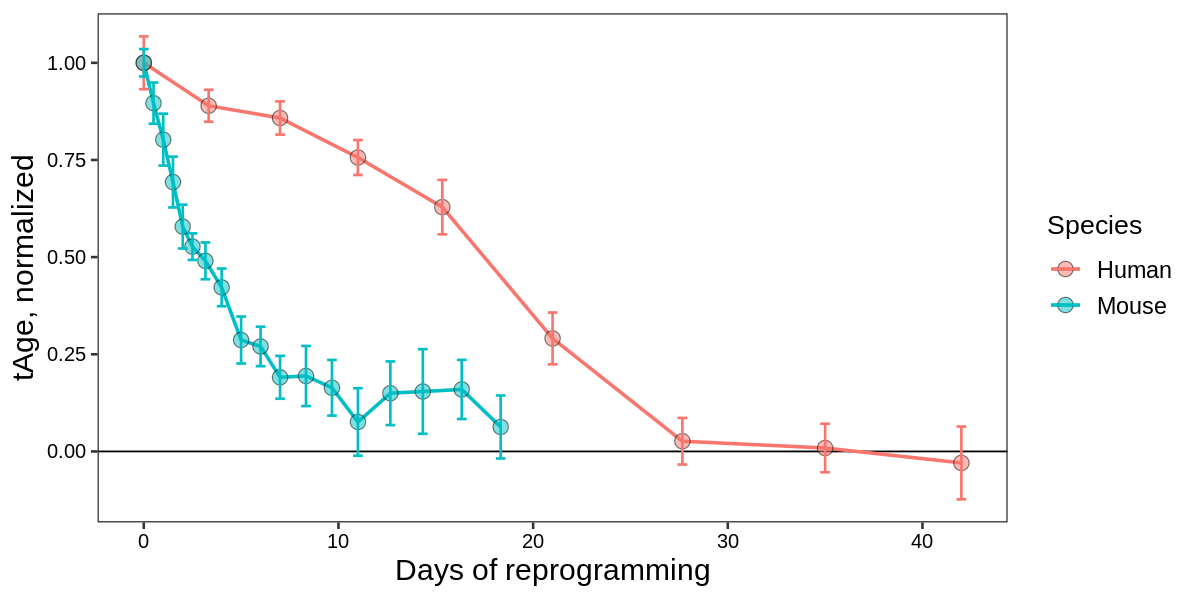

In [12]:

#5. Visualize human and mouse plots together
ma_outputs <- rbind(human_ma_output,mouse_ma_output)
for (i in c("SE","Mean")){
  for (j in c("Mouse","Human")){
    print(ma_outputs[ma_outputs$Species==j & ma_outputs$Time==0,]$Mean)
    ma_outputs[ma_outputs$Species==j,i] <- ma_outputs[ma_outputs$Species==j,i]/ma_outputs[ma_outputs$Species==j & ma_outputs$Time==0,]$Mean
  }
}
limits <- aes(ymin=Mean-SE,ymax=Mean+SE)
t <- ggplot(ma_outputs,aes(x=Time,y=Mean,fill=Species,color=Species))+
  labs(x="Days of reprogramming",y="tAge, normalized")+
  theme_bw(base_size = 16)+geom_hline(yintercept = 0,color="black",lty=1)+
  geom_line(aes(color=Species),lwd=1)+
  geom_point(colour="black",size=4,shape=21,alpha=0.5)+
  geom_errorbar(limits,width=0.5,size=0.75)+
  theme(plot.title = element_text(size=18,hjust = 0.5,face="bold",color="black"),
        axis.text.x = element_text(angle = 0, hjust = 0.5,size=12,color="black"),
        axis.text.y = element_text(size=12,color="black"),
        axis.title=element_text(size=18),
        legend.title=element_text(size=14+2,color="black"),
        legend.text=element_text(size=14,color="black"),
        legend.key.size = unit(1.5, 'lines'),
        panel.grid = element_blank(),
        strip.background =element_rect(fill="white"),
        strip.text = element_text(size=12,face="bold"))
print(t)